In [1]:
%matplotlib inline


# Viewlims


Creates two identical panels.  Zooming in on the right panel will show
a rectangle in the first panel, denoting the zoomed region.



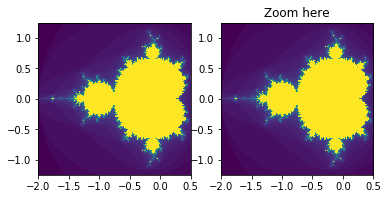

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# We just subclass Rectangle so that it can be called with an Axes
# instance, causing the rectangle to update its shape to match the
# bounds of the Axes
class UpdatingRect(Rectangle):
    def __call__(self, ax):
        self.set_bounds(*ax.viewLim.bounds)
        ax.figure.canvas.draw_idle()


# A class that will regenerate a fractal set as we zoom in, so that you
# can actually see the increasing detail.  A box in the left panel will show
# the area to which we are zoomed.
class MandelbrotDisplay(object):
    def __init__(self, h=500, w=500, niter=50, radius=2., power=2):
        self.height = h
        self.width = w
        self.niter = niter
        self.radius = radius
        self.power = power

    def __call__(self, xstart, xend, ystart, yend):
        self.x = np.linspace(xstart, xend, self.width)
        self.y = np.linspace(ystart, yend, self.height).reshape(-1, 1)
        c = self.x + 1.0j * self.y
        threshold_time = np.zeros((self.height, self.width))
        z = np.zeros(threshold_time.shape, dtype=complex)
        mask = np.ones(threshold_time.shape, dtype=bool)
        for i in range(self.niter):
            z[mask] = z[mask]**self.power + c[mask]
            mask = (np.abs(z) < self.radius)
            threshold_time += mask
        return threshold_time

    def ax_update(self, ax):
        ax.set_autoscale_on(False)  # Otherwise, infinite loop

        # Get the number of points from the number of pixels in the window
        dims = ax.patch.get_window_extent().bounds
        self.width = int(dims[2] + 0.5)
        self.height = int(dims[2] + 0.5)

        # Get the range for the new area
        xstart, ystart, xdelta, ydelta = ax.viewLim.bounds
        xend = xstart + xdelta
        yend = ystart + ydelta

        # Update the image object with our new data and extent
        im = ax.images[-1]
        im.set_data(self.__call__(xstart, xend, ystart, yend))
        im.set_extent((xstart, xend, ystart, yend))
        ax.figure.canvas.draw_idle()

md = MandelbrotDisplay()
Z = md(-2., 0.5, -1.25, 1.25)

fig1, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Z, origin='lower', extent=(md.x.min(), md.x.max(), md.y.min(), md.y.max()))
ax2.imshow(Z, origin='lower', extent=(md.x.min(), md.x.max(), md.y.min(), md.y.max()))

rect = UpdatingRect([0, 0], 0, 0, facecolor='None', edgecolor='black', linewidth=1.0)
rect.set_bounds(*ax2.viewLim.bounds)
ax1.add_patch(rect)

# Connect for changing the view limits
ax2.callbacks.connect('xlim_changed', rect)
ax2.callbacks.connect('ylim_changed', rect)

ax2.callbacks.connect('xlim_changed', md.ax_update)
ax2.callbacks.connect('ylim_changed', md.ax_update)
ax2.set_title("Zoom here")

plt.show()